# Setup everything

### Do imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# --- Import modules --- #
import numpy as np
import matplotlib.pyplot as plt

import os 
import os.path as op

import mne
from mne import pick_types, find_layout
from mne.io import read_info
from mne.viz import plot_topomap
from mne import stats as st




### Define necessary functions

In [3]:
# -- Define function that can read info from both fif and ds files -- #
import contextlib

# -- Works both in python2 and python3 -- #
try:
    from cStringIO import StringIO
except ImportError:
    from io import StringIO
# --------------------------------------- #
    
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = StringIO()
    yield
    sys.stdout = save_stdout

def read_info_custom(fname):
    from os.path import splitext
    _,ext = splitext(fname)
    if ext == '.fif':
        from mne.io import read_info
        info = read_info(fname)
    elif ext == '.ds':
        from mne.io import read_raw_ctf
        with nostdout():
            raw = read_raw_ctf(fname)
        info = raw.info
    else:
        raise RuntimeError('Unknown format for {}'.format(fname))
    return info

In [4]:
# --- This function is dataset-specific ---------- #
def LoadSczPowerData(dirname, missing_channel_id=245):
    """Load and gather .npy data for different subjects in [dir]. Dataset-specific"""
    data = list()
    # Needs to be written;
    for fname in os.listdir(dirname):
        abs_fname = os.path.join(dirname, fname)
        cur_matr = np.load(abs_fname).mean(axis=0) # load and average power across trials
        # some of CTF files for in our dataset have 275 MEG channels 
        # while others have all 
        if cur_matr.shape[0] == 276: 
            cur_matr = np.delete(cur_matr, missing_channel_id)
        cur_matr_no_eeg = cur_matr[:-4] # remove eeg channels
#         print cur_matr_no_eeg.shape
        data.append(cur_matr_no_eeg)
#         print '"' + fname + '"' + ':'
    data = np.array(data)
#     print data.shape
    return data

In [5]:
def GetStatMask(cond1, cond2, p_thresh=0.01):
    """Produce sensor-level binary statistical mask using permutations t-test"""
    # -- cond1 and cond2 should both have shape [n_samples x n_chan] -- #
    if cond1.shape == cond2.shape:
        n_ch = cond1.shape[1]
    else:
        raise RuntimeError('Different sizes for cond1 with shape {} and cond2 with shape {}'.format(cond1.shape, cond2.shape))
    # ----------------------------------------------------------------- #
    diff = cond1 - cond2
    n_permutations = 100000
    # --- Permutation t-test with multiple comparisons correction --- #    
    T_obs, p_vals_corr, H0  = st.permutation_t_test(diff, n_permutations=n_permutations) 
    mask = np.array(p_vals_corr <= p_thresh)
    return mask, p_vals_corr

In [65]:
def plot_colormap(data, pos, mask=None, mask_params=None, title=None):
# def plot_colormap(data, pos, title=None):
    
    
    # ----- Plotting ---------------- #
    
    
    #data = diff_data.mean(axis=0)
    # sensors_pos = pos_no_eeg

    fig1 = plt.figure(figsize=(5,5)) # setup figure
#     plt.figure()
    ax,_ = plot_topomap(data, pos, cmap='viridis', show=False, vmin = '-2.4e-27' , vmax = '2.4e-27') # plot data
    
    #ax,_ = plot_topomap(data, pos, cmap = 'viridis', mask=mask, mask_params=mask_params, show=False) # plot data
    
    
#     fig.colorbar(ax)#, shrink=0.7)
    plt.title(title)

#vmin = '2.4e-27' , vmax = '-2.4e-27' ,
 
    
#     plt.subplot(1, 2, 1)
#     ax,_ = plot_topomap(data, pos, cmap='viridis', mask=mask, mask_params=mask_params, show=False) # plot data
#     fig.colorbar(ax, shrink=0.7)
#     plt.title('Power difference mean (stars for significant sensors)')

#     plt.subplot(1, 2, 2)
#     data_var = diff_data.var(axis=0)
#     # fig = plt.figure(figsize=fsize) # setup figure
#     ax,_ = plot_topomap(data_var, pos, cmap='viridis', mask=mask, mask_params=mask_params, show=False) # plot data
#     plt.colorbar(ax, shrink=0.7)
#     plt.title('Power difference variance (stars for significant sensors)')

#     plt.show(fig)

### Setup parameters

In [7]:
# ---------- Setup stuff for plotting  ------------ #
# info_file = '/home/dmalt/Documents/Control/Control01/Control01_Closed.ds'  
# info needed to get sensors positions
# For .ds files info in a case of missing channel should 
# pick info_file with 271 meg channels, not 272


#                            | CHANGE THIS  |
#                           \/             \/
info_file = '/home/karim/Documents/Veronique/scripts/NEWPATIENT01_Open.ds' 
            #/home/dmalt/Dropbox/aut_gamma/K0001/K0001/K0001ec-epo.fif'
#                      /\   /\   /\   /\   /\   /\
#                      |    |    |    |    |    |
# ----------------------------------------------------------------------- #
    
info = read_info_custom(info_file)   # <-- works both with ctf and electa
layout = find_layout(info)           # <-- Get sensor positions. 

fsize = (16,7)
mask_params = dict(marker='*', markerfacecolor='m', markersize=10) # significant sensors appearence

In [8]:
plot_topomap?

In [9]:
# # ----------- ONLY FOR ELECTA (.fif) ------------- #

# # --- Setup indexing for different sensor types --- #
# # For ctf data this should be changed #
# grads1 = pick_types(info, meg='planar1')
# grads2 = pick_types(info, meg='planar2')
# mags   = pick_types(info, meg='mag')
# grads  = pick_types(info, meg='grad')

# ch_used = grads
# # ------------------------------------------------- #

In [10]:
# -------- IF THE DATA ARE CTF (.ds) EXECUTE THIS -------- #
ch_used = pick_types(info, meg=True, ref_meg=False, eeg=False) # use only axial gradiometers
if ch_used.shape[0] != 271:
    print 'WARNING: in case of "missing channel" ch_used.shape should be (271,), not {}'.format(ch_used.shape)

Channels missing in 271 set compared to 275 layout: ['MLT32' 'MLT36' 'MRO41' 'MRT36']
Their indices in 275-layout: [112, 116, 201, 248]


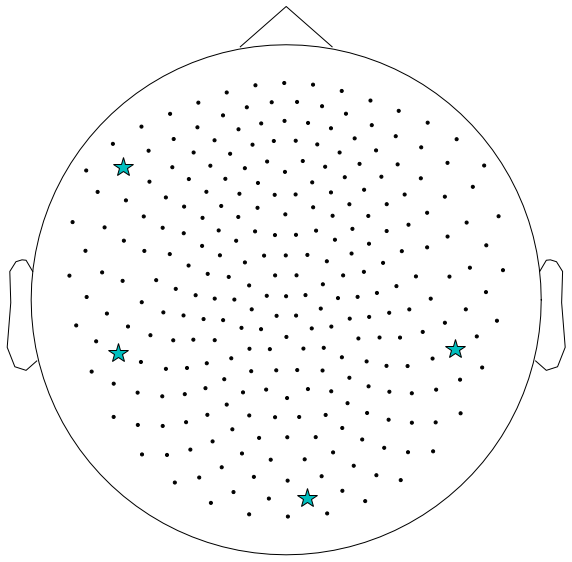

In [11]:
# ----------------- Setup sensor positions ------------------------ # 
# This cell should work both for ctf and electa data

#  Pick between ds and fif options for ch_names_info initialization
ch_names_info = [ch_name[:-5] for ch_name in info['ch_names']] # for .ds data; remove "-3305" postfix in ch_names
# ch_names_info = [ch_name for ch_name in info['ch_names']] # for .fif data

ch = np.ma.MaskedArray(ch_names_info, mask=True)
ch.mask[ch_used] = False # mark false for valid data, true for bads

# Create a masked array of ch_names for a standard layout masking out 
# names that are missing in info
ch_names_ma = np.ma.MaskedArray(layout.names, mask=[c not in ch[~ch.mask] for c in layout.names])
sensors_pos = layout.pos[~ch_names_ma.mask] # positions for sensors present in the data

print 'Channels missing in 271 set compared to 275 layout:', ch_names_ma.data[ch_names_ma.mask]
print 'Their indices in 275-layout:', [i for i in xrange(len(ch_names_ma.mask)) if ch_names_ma.mask[i]]

# Plot missing channels
rand_data = np.ones(275)
sen_all = layout.pos
mask_miss = ch_names_ma.mask
fig=plt.figure(figsize=(10,10))
# mask_miss[248] = False
m_params_miss = dict(marker='*', markerfacecolor='c', markersize=20) # significant sensors appearence
a, c = plot_topomap(rand_data, sen_all, cmap='gray',contours=None, mask=mask_miss, mask_params=m_params_miss)

In [12]:
# ----- Figure out which channel is missing (usually 245). For scz ctf dataset ----- #

# pick two info files - one with a complete set of 272 meg channels
# and the other with missing channel 
info_compl_fname = '/home/karim/Documents/Veronique/scripts/Control14_Closed.ds'
info_miss_fname = '/home/karim/Documents/Veronique/scripts/Control12_Closed.ds'

# # read info files
info_compl = read_info_custom(info_compl_fname)
info_miss = read_info_custom(info_miss_fname)

miss_ch_name = [ch_name for ch_name in info_compl['ch_names'] if ch_name not in info_miss['ch_names']][0]
miss_ch_id = list(np.array(info_compl['ch_names'])[ch_used]).index(miss_ch_name)

print 'Missing channel name: ' + miss_ch_name
print 'Missing channel number (relative to 272-channels set): ', miss_ch_id, '(0-based)'

Missing channel name: MRT36-3305
Missing channel number (relative to 272-channels set):  245 (0-based)


In [13]:
# In case we don't have info files
# miss_ch_id = 245 

# Interesting stuff starts here

### Load data 

In [62]:
# --------------- LOAD DATA --------------------- #
# This cell is dataset-specific.
# Load data for power statistical analysis for scz ctf dataset
# can be changed to plot connectivity. 
# Define paths to two folders which 
# contain data for two conditions we want to compare and load the data

# conditions: Closed, Open
# bands: delta, theta, alpha, beta, lowgamma, highgamma

# INPUTS:
# miss_ch_id       - missing channel 
# LoadSczPowerData - data loading function

# OUTPUTS: 
# cond1_data
# cond2_data
# diff_data


# ----------------- Modify these params ------------------------- ##
cond = 'Closed'
#cond = 'Open'

#band = 'delta'
#band = 'theta'
#band = 'alpha'
#band = 'beta'
#band = 'lowgamma'
band = 'highgamma'
# --------------------------------------------------------------- #
gr1_name = 'Controls'
gr2_name = 'Patients'
basedir = '/home/karim/Documents/Veronique/power_pipeline_output/'

subdir1 = gr1_name + '_' + cond + '_corr' 
subdir2 = gr2_name + '_' + cond + '_corr' 

cond1_dir = op.join(basedir, subdir1, gr1_name + '_' + cond + '_' + band)
cond2_dir = op.join(basedir, subdir2, gr2_name + '_' + cond + '_' + band)

cond1_data = LoadSczPowerData(cond1_dir, miss_ch_id)
cond2_data = LoadSczPowerData(cond2_dir, miss_ch_id)

# = cond1_data cond2_data

#print 'Data shape:', data.shape

diff_data = cond1_data - cond2_data
print 'Data shape:', diff_data.shape
# ------------------------------------------------ #

Data shape: (25, 271)


In [27]:
# ----- statistical mask setup --------- #
thresh = 0.05
# thresh = 0.01

mask, p_vals = GetStatMask(cond1_data, cond2_data, p_thresh=thresh)
print 'Indices of significant sensors:', [i for i in xrange(len(p_vals)) if p_vals[i] < thresh]

Indices of significant sensors: [116, 123, 124]


In [16]:
# import colormaps as cmaps
# plt.register_cmap(name='viridis', cmap=cmaps.viridis)

CONDITION: Closed, BAND: highgamma


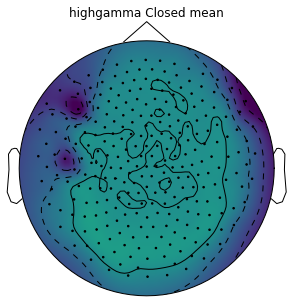

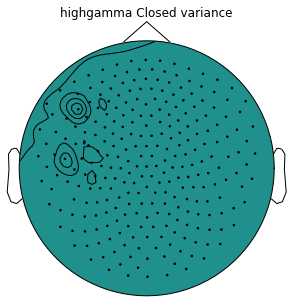

In [63]:
print 'CONDITION: {}, BAND: {}'.format(cond, band)

data_mean = diff_data.mean(axis=0)
data_var = diff_data.var(axis=0)

plot_colormap (data_mean, sensors_pos, mask, mask_params, title = band + ' ' + cond + ' ' + 'mean')

plot_colormap (data_var, sensors_pos, mask, mask_params, title = band + ' ' + cond + ' ' + 'variance')




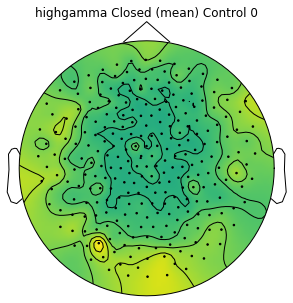

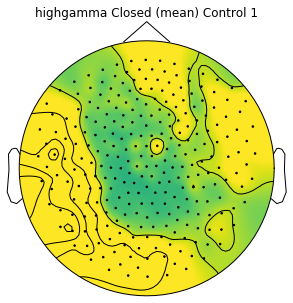

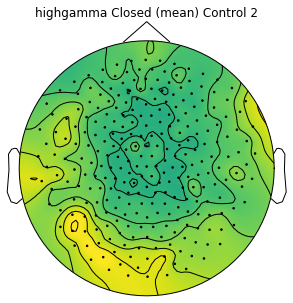

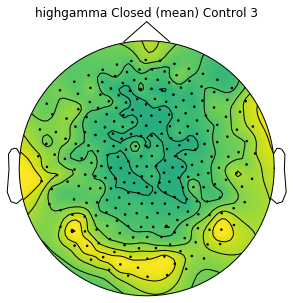

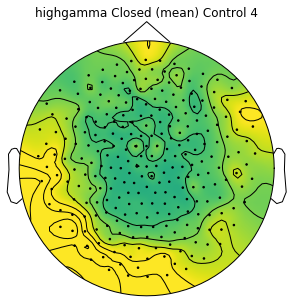

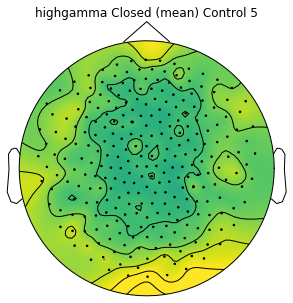

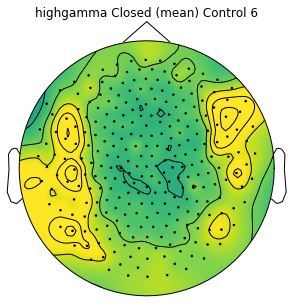

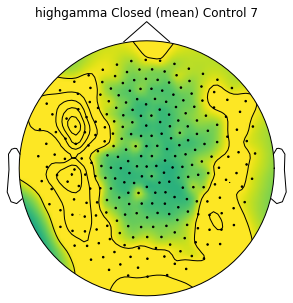

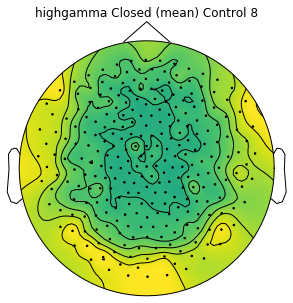

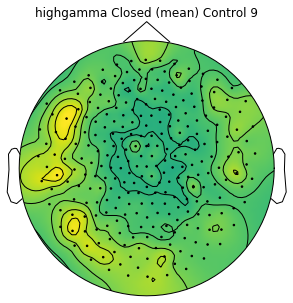

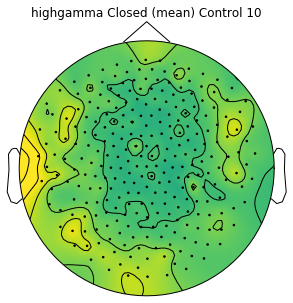

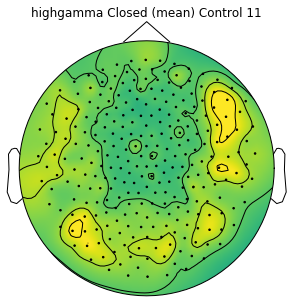

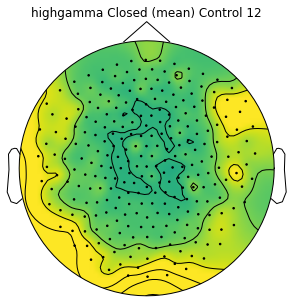

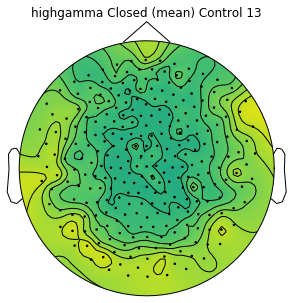

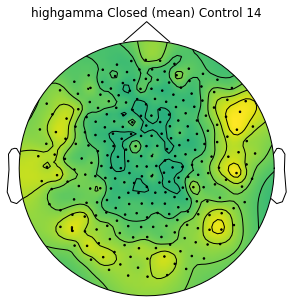

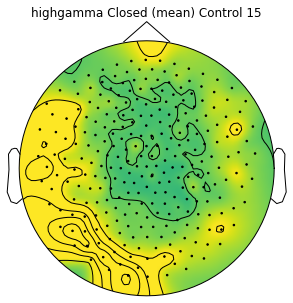

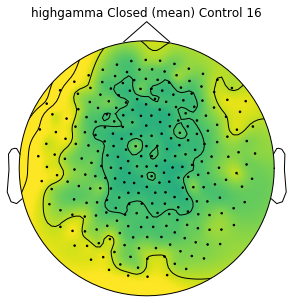

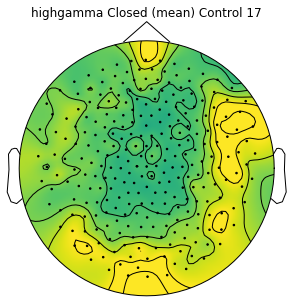

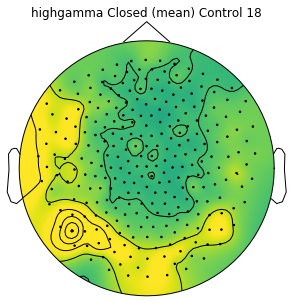

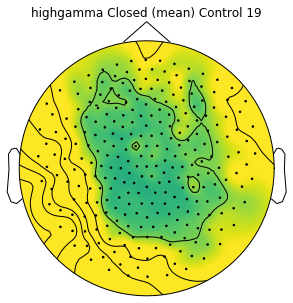

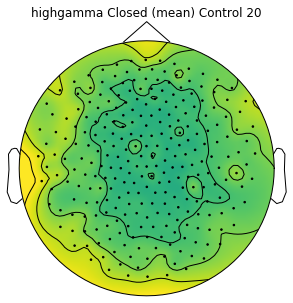

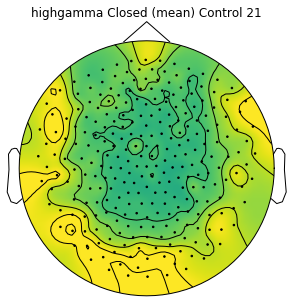

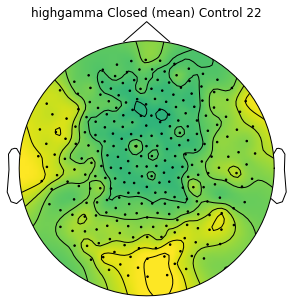

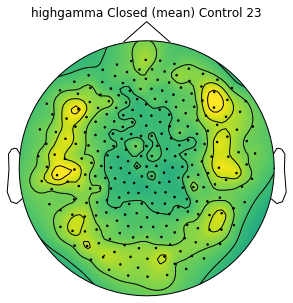

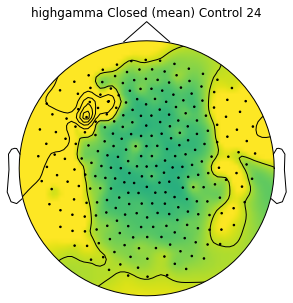

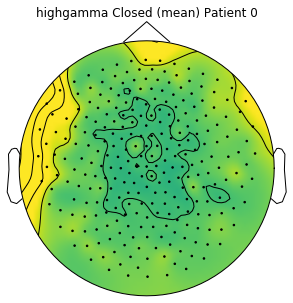

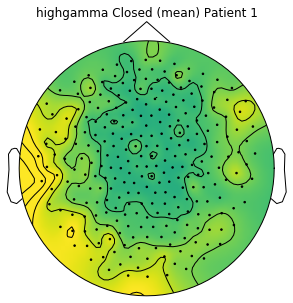

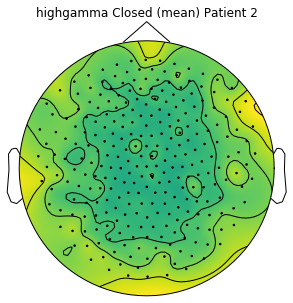

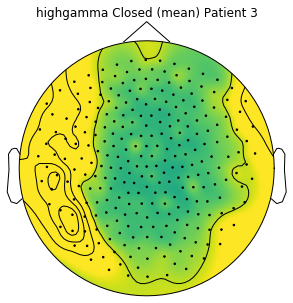

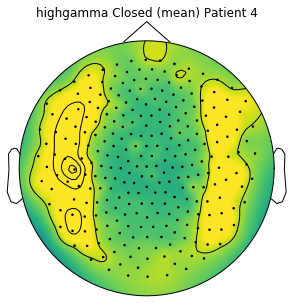

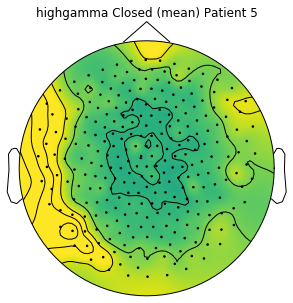

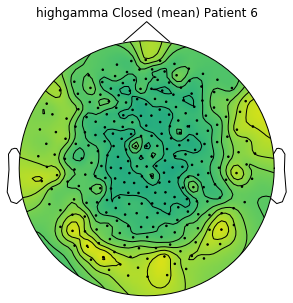

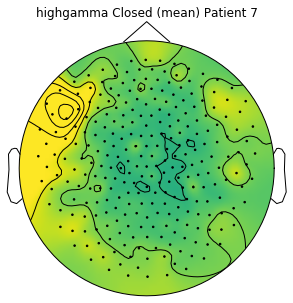

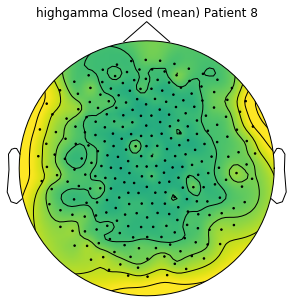

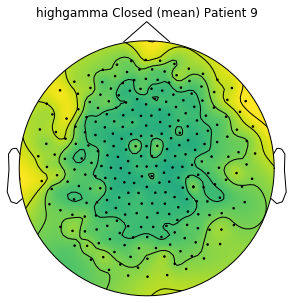

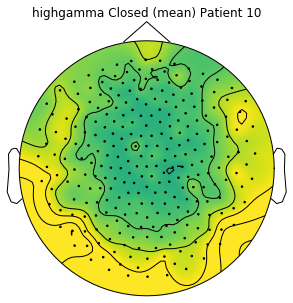

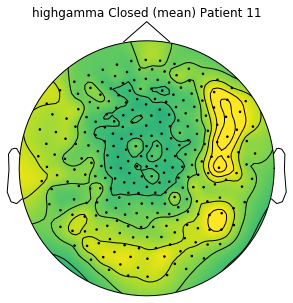

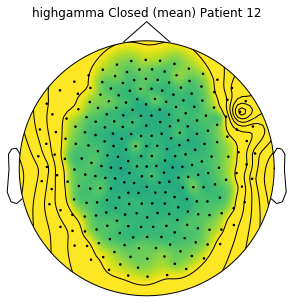

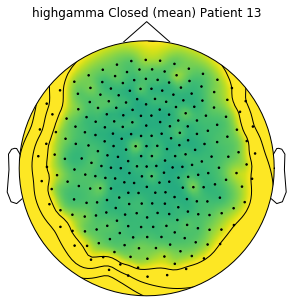

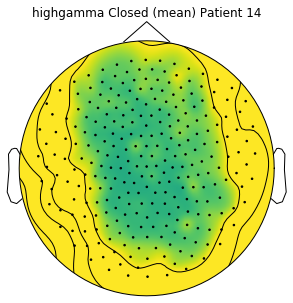

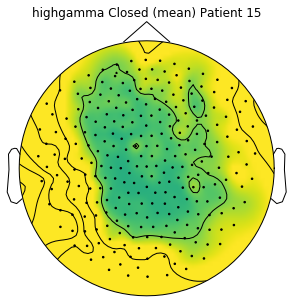

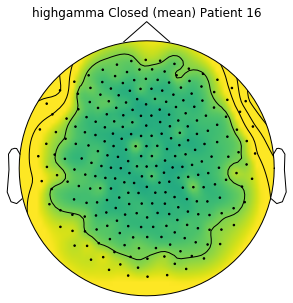

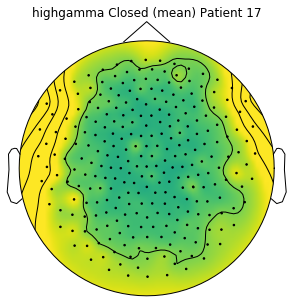

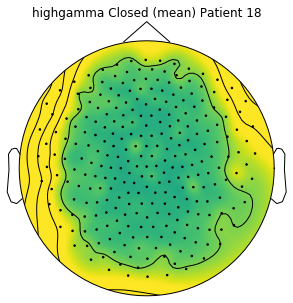

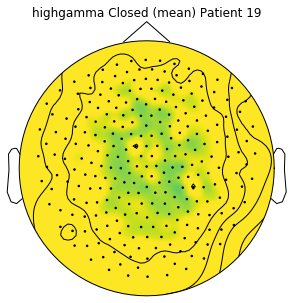

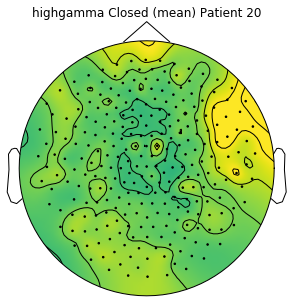

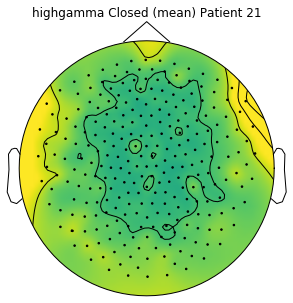

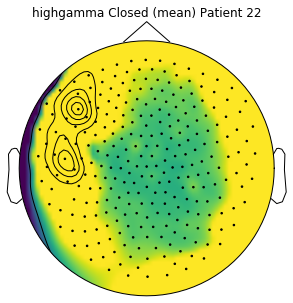

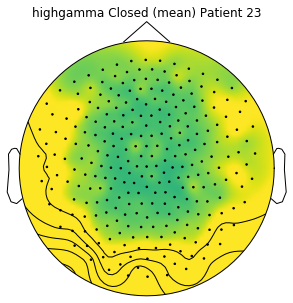

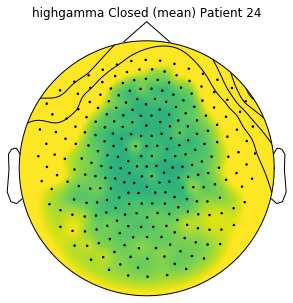

In [64]:
n_iter = cond1_data.shape[0]

for i in range(n_iter):
#     plt.subplot(5,5,i + 1)
    data_i = cond1_data[i,:]
    plot_colormap(data_i, sensors_pos, title = band + ' ' + cond + ' ' + '(mean)' + ' Control ' + str(i))

    
n_iter = cond2_data.shape[0]

for i in range(n_iter):
    data_i = cond2_data[i,:]
    plot_colormap(data_i, sensors_pos, title = band + ' ' + cond + ' ' + '(mean)' + ' Patient ' + str(i))
    
# NB: the number associated with Control or Patient is only associated with a list, not real Control or Patient

# plot_topomap?
# plot_colormap (data_0, sensors_pos, mask, mask_params, title = band + ' ' + cond + ' ' + 'mean')